In [1]:
%%time
import json
import logging
import os
import seaborn as sns
from typing import *
import numpy as np
import pandas as pd
import torch
from transformers import Trainer, TrainingArguments, PreTrainedTokenizerFast, BertTokenizer, BertForSequenceClassification
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import pet
from pet.pvp import PVP, PVPS
from pet.utils import InputExample
from pet.tasks import DataProcessor, PROCESSORS, TASK_HELPERS 
logging.basicConfig(level=logging.CRITICAL)

CPU times: user 955 ms, sys: 168 ms, total: 1.12 s
Wall time: 1.23 s


In [ ]:
model_path = "../../MiniLM"
df_train = pd.read_csv("hw4_train.csv", index_col="id")
df_test = pd.read_csv("hw4_test.csv", index_col="id")

## 1: Tokenize single word into token ID

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 36
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

def tokenize(word: str):
    return tokenizer(word, add_special_tokens=False, padding=False)["input_ids"]

## 2. 10 different prompts for classification and at least 2 verbalizations.

1. In summary, [Review text] sounds [Mask]!
2. If someone say [Review text] to me, he must be a [Mask] guy.
3. How can anyone say [Review text]? He must be so [Mask]!
4. Saying something like [Review text] can make the conversation [Mask].
5. Only [Mask] people will say [Review text] to each other!
6. It sounds [Mask] to say [Review text]
7. I say [Review text] when it is [Mask].
8. [Review text]: [Mask].
9. I feel [Mask] when hearing people say [Review text].
10. How does [Review text] sounds like? It is [Mask].

In [ ]:
class MyTaskPVP(PVP):
    TASK_NAME = "SI630-HW4"
    VERBALIZER = {"0": ["boring","ordinary"], "1": ["toxic", "awful"]}
    def get_parts(self, example: InputExample):
        """
        This function defines the actual patterns: It takes as input an example and outputs the result of applying a
        pattern to it. To allow for multiple patterns, a pattern_id can be passed to the PVP's constructor. This
        method must implement the application of all patterns.
        """
        text = self.shortenable(example.text_a)
        patterns = {
            0: ["In summary, ", text, " sounds ", self.mask, "!"],
            1: ["If someone says ", text, " to me, he must be a ", self.mask, " guy."],
            2: ["How can anyone say ", text, "? He must be so ", self.mask, "!"],
            3: ["Saying something like ", text, "can make the conversation ", self.mask, "."],
            4: ["Only ", self.mask, " people will say ", text, " to each other!"],
            5: ["It sounds ", self.mask, " to say ", text, "."],
            6: ["I say ", text, " when it is ", self.mask, "."],
            7: [text, ": ", self.mask, "."],
            8: ["I feel ", self.mask, " when hearing people say ", text, "."],
            9: ["How does ", text, " sounds like? It is ", self.mask, "."]
        }
        if self.pattern_id in patterns.keys():
            return patterns[self.pattern_id]
        else:
            raise ValueError("No pattern implemented for id {}".format(self.pattern_id))

    def verbalize(self, label) -> List[str]:
        return MyTaskPVP.VERBALIZER[label]


# register the PVP for this task with its name
PVPS[MyTaskPVP.TASK_NAME] = MyTaskPVP

In [ ]:
class MyTaskDataProcessor(DataProcessor):
    """
    Example for a data processor.
    """
    TASK_NAME = "SI630-HW4"
    TRAIN_FILE_NAME = "hw4_train.csv"
    TEST_FILE_NAME = "hw4_test.csv"

    LABELS = ["0", "1"]

    def get_train_examples(self, data_dir: str=".", size: int=-1) -> List[InputExample]:
        return self._create_examples(os.path.join(data_dir, MyTaskDataProcessor.TRAIN_FILE_NAME), "train", size=size)

    def get_test_examples(self, data_dir: str=".", size: int=-1) -> List[InputExample]:
        return self._create_examples(os.path.join(data_dir, MyTaskDataProcessor.TEST_FILE_NAME), "test", size=size)

    def get_dev_examples(self, data_dir: str=".") -> List[InputExample]:
        return self._create_examples(os.path.join(data_dir, MyTaskDataProcessor.DEV_FILE_NAME), "dev")

    def get_unlabeled_examples(self, data_dir: str=".") -> List[InputExample]:
        return self._create_examples(os.path.join(data_dir, MyTaskDataProcessor.UNLABELED_FILE_NAME), "unlabeled")
    
    def get_labels(self) -> List[str]:
        """This method returns all possible labels for the task."""
        return MyTaskDataProcessor.LABELS
    
    def _create_examples(self, path, set_type, max_examples=-1, skip_first=0, size: int=-1):
        """Creates examples for the training and dev sets."""
        examples = []
        df = pd.read_csv(path)
        if size != -1:
            ratio = size / len(df)
            df_toxic = df[df.toxic==1]
            df_nontoxic = df[df.toxic==0]
            df = pd.concat([df_toxic.sample(int(ratio * len(df_toxic))), df_nontoxic.sample(int(ratio * len(df_nontoxic)))])
        for idx, row in df.iterrows():
            guid = "%s-%s" % (set_type, idx)
            example = InputExample(guid=guid, text_a=row.comment_text, text_b=None, label=str(row.toxic))
            examples.append(example)     
        return examples
PROCESSORS[MyTaskDataProcessor.TASK_NAME] = MyTaskDataProcessor

## 3. Train MiniLM at least for 2 epochs and validate by F1

In [ ]:
%%time
train_tokenized = tokenizer(list(df_train.comment_text), padding=True, truncation=True, max_length=256)
train_dataset = Dataset(train_tokenized, list(df_train.toxic))
test_tokenized = tokenizer(list(df_test.comment_text), padding=True, truncation=True, max_length=256)
test_dataset = Dataset(test_tokenized, list(df_test.toxic))

In [ ]:
def compute_metrics(pred):    
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(y_true=labels, y_pred=preds)
    recall = recall_score(y_true=labels, y_pred=preds, average='micro')
    precision = precision_score(y_true=labels, y_pred=preds, average='micro')
    f1 = f1_score(y_true=labels, y_pred=preds, average='micro')
    return {"acc":acc, "recall":recall, "precision": precision, "f1": f1}

def train(model, train_dataset):
    model.to(device)
    args = TrainingArguments(
        output_dir="output",
        evaluation_strategy="steps",
        eval_steps=500,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=2,
        seed=123,
        load_best_model_at_end=True,
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics
    )
    trainer.train()
    return model

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)
train_model_path = "MiniModelRegression"
trained_model = train(model, train_dataset)
# trained_model = BertForSequenceClassification.from_pretrained(train_model_path, num_labels=1)
trained_predictor = Trainer(model=trained_model)
trained_predictor.save_model(train_model_path)

In [ ]:
%%time
prediction = trained_predictor.predict(test_dataset).predictions
pred_label = np.argmax(prediction, axis=1).flatten()
acc = accuracy_score(pred_label, df_test.toxic)
f1 = f1_score(pred_label, df_test.toxic)

For MiniLM bert model, Acc is $0.92$, F1 is $0.67$ 

## 4. Use pattern and verbalizer to train PET on 10, 50, 100, 500 random instances 

In [ ]:
%%time
for size in [10, 50, 100, 500]:
    model_config = pet.WrapperConfig("bert", model_path, "sequence_classifier", "SI630-HW4", 256, ["0", "1"], list(range(10)))
    train_config = pet.TrainConfig(str(device), batch_size, batch_size)
    eval_config = pet.EvalConfig(str(device), per_gpu_eval_batch_size=batch_size, metrics=["acc", "f1"])
    output_dir = "output{}".format(size)
    train_data = MyTaskDataProcessor().get_train_examples(".", size=size)
    test_data = MyTaskDataProcessor().get_test_examples(".", size=size)
    pattern_ids = list(range(10))
    pet.train_pet_ensemble(model_config, train_config, eval_config, pattern_ids, output_dir,train_data=train_data, eval_data=test_data)

For PET10, acc is $0.46\pm0.37$, F1 is $0.18\pm0.12$

For PET50, acc is $0.53\pm0.37$, F1 is $0.26\pm0.14$

For PET100, acc is $0.55\pm0.21$, F1 is $0.29\pm0.06$

For PET500, acc is $0.84\pm0.02$, F1 is $0.52\pm0.02$

## 5. Use Seaborn to plot F1 for PET and MiniLM

In [2]:
data = pd.DataFrame({
    "Model":["PET10", "PET50", "PET100", "PET500", "MiniLM"],
    "Acc":[0.46, 0.53, 0.55, 0.84, 0.92],
    "F1": [0.18, 0.26, 0.29, 0.52, 0.67]
    }
).melt(id_vars=["Model"], value_vars=["Acc", "F1"], var_name="ScoreType", value_name="Value").sort_values(["Model", "ScoreType"])

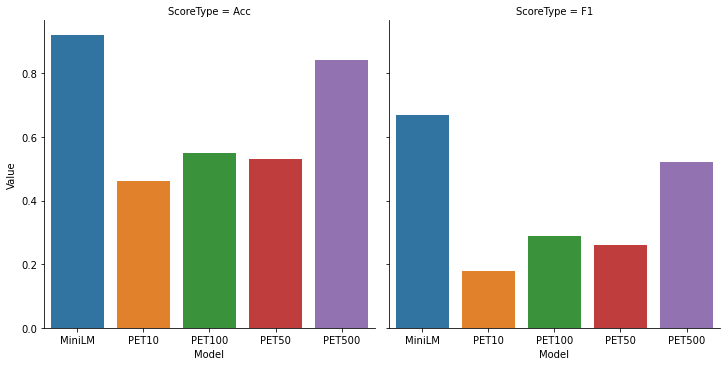

In [3]:
sns.catplot(data=data, x="Model", col="ScoreType", y="Value", kind="bar")

With more instance used for PET model's training, the score for PET 500 increase greatly. The score for PET 500 is quite close to the MiniLM model. Therefore, I think 1000 samples should be enough for PET model to reach MiniLM model.